In [1]:
from prefect import task, Flow

In [2]:
%run load_station.py

C01R01_gate step 0.0005
C01R01_gate inter_delay 0.00125


In [3]:
from typing import Tuple

from nanotune.tuningstages.base_tasks import (
    SetpointSettingsDict,
    DataSettingsDict,
    ReadoutDict,
    compute_linear_setpoints,
    swap_range_limits_if_needed,
    get_current_voltages,
    take_data_add_metadata,
    set_up_gates_for_measurement,
    prepare_metadata
)

from nanotune.tuningstages.take_data import ramp_to_setpoint

In [4]:
@task
def create_settings() -> Tuple[SetpointSettingsDict, ReadoutDict, DataSettingsDict]:
    setpoint_settings = SetpointSettingsDict(
        parameters_to_sweep=[chip.C01R01.gate],
        current_valid_ranges=[(-2.0, 0.0)],
        safety_voltage_ranges=[(-2.0, 2.0)],
        voltage_precision=0.01
    )

    readout_methods = ReadoutDict(
        transport = chip.C01R01.source,
        sensing = chip.C01R01.drain,
        rf = mux.readout
    )

    data_settings = DataSettingsDict(
        db_name="forqtest",
        db_folder="~",
        normalization_constants={"foo": (1.0, 1.0)},
        segment_size=1,
        segment_db_name="forqtest_1",
        segment_db_folder="~"
    )

    return (
        setpoint_settings,
        readout_methods,
        data_settings
    )

In [5]:
@task
def compute_setpoints(setpoint_settings):
    initial_voltages = get_current_voltages(
        setpoint_settings["parameters_to_sweep"]
    )

    current_valid_ranges = swap_range_limits_if_needed(
        initial_voltages,
        setpoint_settings["current_valid_ranges"]
    )

    setpoints = compute_linear_setpoints(
        current_valid_ranges,
        setpoint_settings["voltage_precision"],
    )
    return setpoints

In [6]:
@task
def measure(setpoints, setpoint_settings, data_settings, readout_methods):
    example_param = setpoint_settings["parameters_to_sweep"][0]
    device_name = example_param.name_parts[0]
    nt_meta = prepare_metadata(
        chip.C01R01.name,
        data_settings[normalization_constants"],
        readout_methods,
    )
    sensing = readout_methods["sensing"]

    def finish_early(current_output_dict):
        return current_output_dict[str(sensing)] < 0.0001

    run_id = take_data_add_metadata(
        setpoint_settings["parameters_to_sweep"],
        list(readout_methods.values()),  # type: ignore
        setpoints,
        finish_early_check=finish_early,
        do_at_inner_setpoint=ramp_to_setpoint,
        pre_measurement_metadata=nt_meta,
    )

    return run_id

In [7]:
@task
def plot(run_id, setpoint_settings, readout_methods):
    ds = qc.load_by_id(run_id)
    gate = setpoint_settings["parameters_to_sweep"][0]
    sensing = readout_methods["sensing"]
    df_dict = ds.to_pandas_dataframe_dict()
    df_dict[str(sensing)].plot()

In [8]:
with Flow("Pinch-off") as flow:
    (setpoint_settings, readout_methods, data_settings) = create_settings()
    setpoints = compute_setpoints(setpoint_settings)
    run_id = measure(setpoints, setpoint_settings, data_settings, readout_methods)
    fig = plot(run_id, setpoint_settings, readout_methods)

[2021-05-26 20:14:24-0700] INFO - prefect.FlowRunner | Beginning Flow run for 'Pinch-off'
[2021-05-26 20:14:24-0700] INFO - prefect.TaskRunner | Task 'create_settings': Starting task run...
[2021-05-26 20:14:24-0700] INFO - prefect.TaskRunner | Task 'create_settings': Finished task run for task with final state: 'Success'
[2021-05-26 20:14:24-0700] INFO - prefect.TaskRunner | Task 'create_settings[0]': Starting task run...
[2021-05-26 20:14:24-0700] INFO - prefect.TaskRunner | Task 'create_settings[0]': Finished task run for task with final state: 'Success'
[2021-05-26 20:14:24-0700] INFO - prefect.TaskRunner | Task 'compute_setpoints': Starting task run...
[2021-05-26 20:14:24-0700] INFO - prefect.TaskRunner | Task 'compute_setpoints': Finished task run for task with final state: 'Success'
[2021-05-26 20:14:24-0700] INFO - prefect.TaskRunner | Task 'create_settings[1]': Starting task run...
[2021-05-26 20:14:24-0700] INFO - prefect.TaskRunner | Task 'create_settings[1]': Finished task

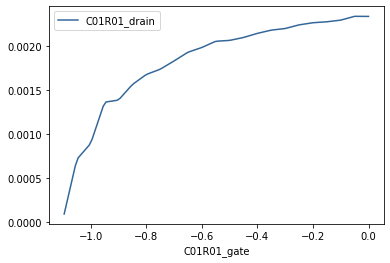

In [9]:
state = flow.run()